# Online Convex Optimization

Данные будем брать из этого датасета:
https://archive.ics.uci.edu/ml/datasets/spambase

In [43]:
# подключение необходимых библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
%matplotlib inline

In [73]:
spam_data = pd.read_csv('spambase.data', header=None)

d = 55
spam_data.columns = np.arange(0, 58)
print(d)
spam_data.head()

55


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Заметим, что в данном датасете сначала идут те сообщения, которые являются спамом, а потом - те, которые не являются. Это может негативно сказаться на качестве работы алгоритмов. Поэтому сделаем `shuffle` строк датасета при помощи функции `pandas.sample`.

In [81]:
spam_data = spam_data.sample(frac=1)
spad_data = pd.DataFrame(spam_data.values, columns=spam_data.columns)
spam_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
1895,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.14,0.00,...,0.058,0.156,0.000,0.000,0.000,0.000,1.687,24,496,0
4178,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.86,...,0.000,0.321,0.000,0.214,0.000,0.000,3.956,51,91,0
1514,0.00,0.00,0.00,0.0,0.00,1.36,0.00,0.00,1.36,0.00,...,0.000,0.000,0.000,1.777,0.222,0.000,9.727,63,107,1
3204,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.091,0.000,0.045,0.000,0.000,2.333,15,175,0
25,0.05,0.07,0.10,0.0,0.76,0.05,0.15,0.02,0.55,0.00,...,0.042,0.101,0.016,0.250,0.046,0.059,2.565,66,2258,1
1740,0.00,0.00,0.00,0.0,0.65,0.00,0.65,0.00,0.00,0.00,...,0.000,0.000,0.000,1.765,0.000,0.000,3.025,21,118,1
2382,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.188,0.376,0.000,0.000,2.310,15,67,0
1337,0.00,0.00,0.00,0.0,0.00,0.00,1.15,0.00,0.00,0.00,...,0.000,0.000,0.000,0.486,0.347,0.000,1.608,6,74,1
1764,0.96,0.00,0.48,0.0,0.00,0.96,0.00,0.00,0.48,0.00,...,0.000,0.818,0.000,0.175,0.467,0.116,9.560,259,717,1
1833,0.00,0.63,0.00,0.0,1.27,0.00,0.00,0.00,0.00,0.00,...,0.000,0.218,0.000,0.000,0.000,0.000,2.215,22,113,0


Для дальнейшего применения алгоритмов разобьём данные на значения признаков и столбец целевой переменной.

In [138]:
X = spam_data[np.arange(d)].values
y = spam_data[57].values

### Online Gradient Descent

Для начала, чтобы убедиться в адекватности построенной модели, применим online градиентный спуск.
Запустим его на разных начальных приближениях.

**Замечание.**

Для получения значений `regret`ов был использован пакет для выпуклой оптимизации `cvxpy`, который получает ответ достаточно медленно. По этой причине я считал эти значения не на всех итерациях алгоритма.

Чтобы не считать значения `regret`, можно не передавать 3 параметр в функцию `online_gradient_descent`.

In [164]:
R = 1.0
G = 0.5
D = 2.0 * R

M = 100.0*R

#объявление необходимых функций

def proection(x):
    if np.linalg.norm(x) <= R:
        return x
    return x / np.linalg.norm(x) * R

def grad(x, w, y_value):
    return (np.dot(x, w) + M - 2.0 * M * y_value) / (2.0*M**2) * w

def calc_opt_value(x_list, y_list):
    w = cvx.Variable(d)
    #print(x_list)
    #print(y_list)
    prob = cvx.Problem(cvx.Minimize(cvx.sum_squares(y_list - (x_list*w + M) / (2*M))), 
                       [cvx.sum_squares(w) <= R**2])

    result = prob.solve(solver=cvx.SCS, verbose=False, eps=0.01)
    return result

def calc_regret(cur_sum, x_list, y_list):
    return cur_sum - calc_opt_value(x_list, y_list)

def online_gradient_descent(x0, T, regrets=None, param_G=G, param_D=D, step_search=None):
    x = x0
    t = 1
    cur_sum = 0
    x_list = []
    
    if step_search is None:
        get_step = lambda x_value, h, f, gradf, it: param_D / (param_G * float(it)**0.5)
    else:
        get_step = lambda x_value, h, f, gradf, it: step_search(x_value, h, f, gradf)
    while t <= T:
        cur_grad = grad(x, X[t - 1], y[t - 1])
        alpha = get_step(x, cur_grad, 
                         lambda z: (y[t - 1] - (np.dot(X[t - 1], x) + M) / (2*M))**2,
                         lambda z: grad(z, X[t - 1], y[t - 1]), t)
        new_x = proection(x - alpha * cur_grad)
        
        x = new_x
        x_list.append(x)
        cur_sum += (y[t - 1] - (np.dot(X[t - 1], x) + M) / (2*M))**2
        if not (regrets is None) and ((t == T) or (t % 500 == 0)):
            regrets.append((t, calc_regret(cur_sum, np.array(x_list), y[:t])))
        t += 1
    return x

In [169]:
def try_online_gd(x0):
    regrets = []
    a = online_gradient_descent(x0, len(spam_data), regrets)
    dots = np.dot(X, a)
    predict = (np.sign(dots) + 1.0) / 2
    regrets = np.array(regrets)

    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))
    print('regrets: ', regrets[:, 1])
    return (regrets[:, 0], regrets[:, 1])
    
regret_matr = []
regret_matr.append(try_online_gd(np.zeros(d)))
regret_matr.append(try_online_gd(np.ones(d) * R / (float(d)**0.5)))
regret_matr.append(try_online_gd(np.hstack(([R], np.zeros(d - 1)))))

('accuracy: ', 0.688980656379048)
('regrets: ', array([22.99572783, 22.66581651, 25.85364603, 26.53133592, 27.51022302,
       31.0192604 , 40.43134484, 41.94297716, 45.16106415, 44.31290297]))
('accuracy: ', 0.6881112801564877)
('regrets: ', array([26.09037452, 25.28907944, 28.12515286, 28.67927867, 29.80053861,
       33.37997693, 42.86624919, 44.38311868, 47.57797763, 46.67361714]))
('accuracy: ', 0.6872419039339274)
('regrets: ', array([16.45508251, 16.18736741, 19.41453563, 20.25417301, 21.39368759,
       24.88476449, 34.34522214, 35.88349857, 39.06370005, 38.24083941]))


Построим графики посчитанных значений $regret$ в каждом случае.

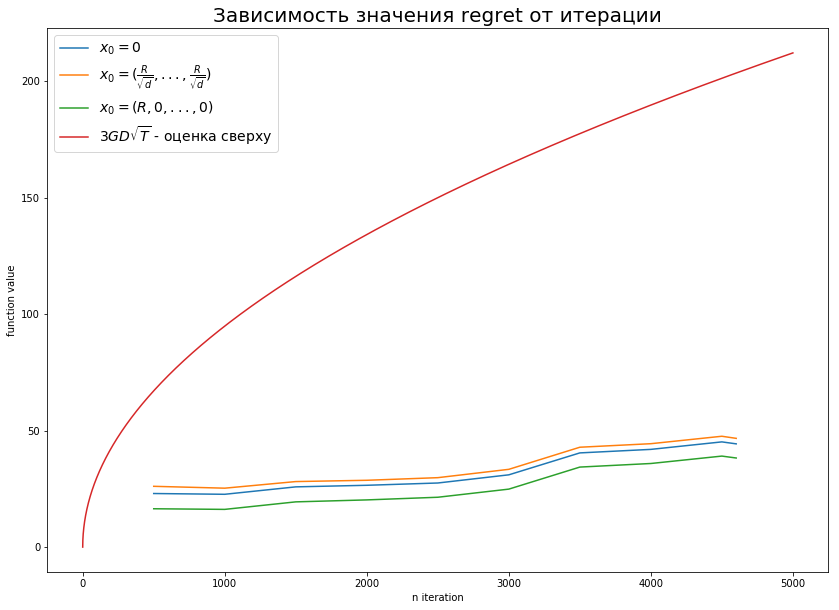

In [170]:
def plot_gd_regrets(regrets, labels=['$x_0=0$', 
                                  '$x_0=(\\frac{R}{\\sqrt{d}}, ..., \\frac{R}{\\sqrt{d}})$',
                                  '$x_0=(R, 0, ..., 0)$']):
    plt.figure(figsize=(14, 10))
    for (regret, label) in zip(regrets, labels):
        plt.plot(regret[0], regret[1], label=label)
        
    grid = np.linspace(0, 5000, 100000)
    plt.plot(grid, 3.0*D*G*(grid**0.5), label=u'$3GD\\sqrt{T}$ - оценка сверху')
        
    plt.legend(fontsize=14)
    plt.title(u'Зависимость значения regret от итерации', fontsize=20)
    plt.xlabel('n iteration')
    plt.ylabel('function value')
    plt.show()

plot_gd_regrets(np.array(regret_matr))

**Вывод.**

1) Как можно увидеть, от начального приближения точность алгоритма не зависит. И графики зависимости значения $regret$ от номера итерации получились при всех трёх рассмотренных начальных приближениях похожими.

2) Теоретические оценки для верхней границы значений $regret$ оказались выполнены, что показывает достаточно.

In [165]:
import ipywidgets as widgets

def display_widget(ip):
    # отображаем слайдеры группами
    display(widgets.HBox(ip.children[:2]))
    display(widgets.HBox(ip.children[2:4]))
    display(widgets.HBox(ip.children[4:6]))
    if len(ip.children) > 7:
        display(widgets.HBox(ip.children[6:len(ip.children)-1]))
    # отображаем вывод функции
    display(ip.children[-1])

    ip.update()  # чтобы функция запустилась до первого изменения слайдеров

In [166]:
def const_step_OGD(param_G, param_D):
    x = online_gradient_descent(np.zeros(d), len(spam_data), regrets=None,
                                param_G=param_G, param_D=param_D)
    print(x)
    dots = np.dot(X, x)
    predict = (np.sign(dots) + 1.0) / 2
    print(predict)
    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))

ip = widgets.interactive(const_step_OGD,
                         param_G=widgets.FloatSlider(min=0.5, max=10, step=0.1, value=0.5),
                         param_D=widgets.FloatSlider(min=2, max=10, step=0.1, value=2));

display_widget(ip)

HBox(children=(FloatSlider(value=0.5, description=u'param_G', max=25.0, min=0.5), FloatSlider(value=2.0, description=u'param_D', max=25.0, min=2.0)))

HBox(children=(Output(),))

HBox()

Output()

**Вывод.**

Как можно увидеть по варьированию значений параметров шага, от изменений шага итоговый вектор фильтра $x$ может варьироваться достаточно сильно. Но при этом значение accuracy достигает до 0.7.

Теперь попробуем другие способы выбора шага. Например, можно выбирать шаг по правилам Армихо и Вольфа.

In [154]:
# отображает на графике значения regret, посчитанные на каждой 500-й итерации

def plot_regrets_every_500(x_values):
    T = len(x_values)
    regrets = []
    cur_sum = 0
    
    for t in range(T):
        cur_sum += (y[t] - (np.dot(X[t], x[t]) + M) / (2*M))**2
        if t % 500 == 0:
            regrets.append(calc_regret(cur_sum, np.array(X[:t]), y[:t]))
    
    plt.figure(figsize=(14, 10))
    plt.plot((1 + np.arange(regrets)) * 500, regrets, label='regret')
        
    plt.legend(fontsize=14)
    plt.title(u'Зависимость значения regret от итерации', fontsize=20)
    plt.xlabel('n iteration')
    plt.ylabel('regret value')
    plt.show()
 
def handle_float(value):
    if len(value.shape) == 0:
        return np.array([np.array([value])])
    return value

def armijo_stepsize(x, h, func, gradf):
    alpha = 1
    rho = 0.5
    beta = 0.3
    assert beta < 0.5, "Armijo rule is applicable for beta less than 0.5"
    assert rho < 1, "Decay factor has to be less than 1"
        
    current_grad = gradf(x)
    current_f = func(x)
    x_next = x + alpha*h
    while True:
        if np.isnan(func(x_next)):
            alpha *= rho
        else:
            if func(x_next) >= current_f + beta * handle_float(current_grad).dot(x_next - x):
                alpha *= rho
            else:
                break
            if alpha < 1e-16:
                break
            x_next = x + alpha*h
    return alpha

def wolfe_step_search(x, h, f, grad):
    rho = 0.5
    beta1 = 0.2
    beta2 = 0.9
    current_grad = grad(x)
    current_f = f(x)
    alpha = 0.95
    while alpha >= 1e-6: 
        if np.isnan(f(x + alpha * h)):
            alpha *= rho
        else:
            if f(x + alpha * h) > current_f + beta1 * alpha * current_grad.dot(h):
                alpha *= rho
            elif h.dot(grad(x + alpha * h)) < beta2 * h.dot(current_grad):
                alpha *= rho
            else:
                break
                
    return alpha

In [167]:
def armijo_OGD():
    x = online_gradient_descent(np.zeros(d), len(spam_data), None, step_search=armijo_stepsize)
    print(x)
    dots = np.dot(X, x)
    print(dots)
    predict = (np.sign(dots) + 1.0) / 2
    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))
    
armijo_OGD()

[ 0.01174244 -0.02362012  0.03170672  0.00263592  0.06347223  0.01117096
  0.04373391  0.02585999  0.01767972  0.05674583  0.01851047 -0.06181869
  0.01416026 -0.01031949  0.02753397  0.0452533   0.03948172  0.04858828
  0.17554251  0.05120644  0.12374616  0.01362833  0.06040117  0.02627459
 -0.24102398 -0.2009831  -0.3592347  -0.06885241 -0.07810881 -0.05580386
 -0.02718829 -0.02253375 -0.0356057  -0.02450266 -0.06422473 -0.03499224
 -0.06506042 -0.00389411 -0.03422961 -0.01680377 -0.00665261 -0.07583931
 -0.01529809 -0.02600348 -0.10521108 -0.04843472 -0.00195119 -0.01559969
 -0.00180743 -0.02766349 -0.00889365  0.1043941   0.03676713  0.01216987
  0.79641704]
[1.16736109 3.63640474 8.1201793  ... 6.08597226 1.97949654 4.55651857]
('accuracy: ', 0.47076722451640945)


In [168]:
def wolfe_OGD():
    x = online_gradient_descent(np.zeros(d), len(spam_data), None, step_search=wolfe_step_search)
    print(x)
    dots = np.dot(X, x)
    print(dots)
    predict = (np.sign(dots) + 1.0) / 2
    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))
    
wolfe_OGD()

[ 0.01141185 -0.02179557  0.03079025  0.00260399  0.06183847  0.01098833
  0.04241995  0.02500111  0.01708759  0.05444032  0.01794492 -0.06074321
  0.01338652 -0.01006342  0.02677632  0.044659    0.03842479  0.04702048
  0.16874986  0.04982739  0.11966478  0.01324742  0.05867563  0.02563547
 -0.23490234 -0.19549055 -0.35184838 -0.06712432 -0.07646532 -0.05420617
 -0.02643903 -0.02189374 -0.03449674 -0.02377743 -0.06224936 -0.03408409
 -0.06305616 -0.00375289 -0.0333833  -0.01629252 -0.00655558 -0.0737884
 -0.01499947 -0.02513463 -0.10317096 -0.0471632  -0.001886   -0.01510236
 -0.0019024  -0.02694723 -0.00869641  0.10115302  0.03549485  0.01159888
  0.80800286]
[1.19127596 3.66103477 8.22066213 ... 6.10245524 1.95703401 4.56955059]
('accuracy: ', 0.46707237557052816)


**Вывод.**

В некоторых задачах Online Convex Optimisation выбор шага по методам Армихо и Вольфа может работать хуже, чем априорный шаг.

### Online Stochastic Gradient Descent